In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, InputLayer
import random
import os
import math
import pylab as p
import seaborn as sns
from datetime import datetime, timedelta
import string

In [283]:
file_path_volts1 = r".\dataset\H2\Tagged_Training_06_15_1339743601\LF1V.csv"
file_path_amps1 = r".\dataset\H2\Tagged_Training_06_15_1339743601\LF1I.csv"
file_path_time_ticks1 = r".\dataset\H2\Tagged_Training_06_15_1339743601\TimeTicks1.csv"

file_path_volts2 = r".\dataset\H2\Tagged_Training_06_15_1339743601\LF2V.csv"
file_path_amps2 = r".\dataset\H2\Tagged_Training_06_15_1339743601\LF2I.csv"
file_path_time_ticks2 = r".\dataset\H2\Tagged_Training_06_15_1339743601\TimeTicks2.csv"

file_path_tagging_info = r".\dataset\H2\Tagged_Training_06_15_1339743601\TaggingInfo.csv"

LF1V = pd.read_csv(file_path_volts1)
LF1I = pd.read_csv(file_path_amps1)
time_ticks1 = pd.read_csv(file_path_time_ticks1)

LF2V = pd.read_csv(file_path_volts2)
LF2I = pd.read_csv(file_path_amps2)
time_ticks2 = pd.read_csv(file_path_time_ticks2)

tagging_info = pd.read_csv(file_path_tagging_info)

In [284]:
LF1V = np.array(LF1V)
LF1I = np.array(LF1I)
LF1V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1V])
LF1I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF1I])

LF2V = np.array(LF2V)
LF2I = np.array(LF2I)
LF2V = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2V])
LF2I = np.array([[complex(y.replace("i", "j")) for y in x] for x in LF2I])

In [285]:
L1_P = LF1V * np.conjugate(LF1I)
L2_P = LF2V * np.conjugate(LF2I)

L1_ComplexPower = np.sum(L1_P, axis=1)
L2_ComplexPower = np.sum(L2_P, axis=1)

L1_real = np.real(L1_ComplexPower)
L1_imag = np.imag(L1_ComplexPower)
L1_app = np.abs(L1_ComplexPower)

L2_real = np.real(L2_ComplexPower)
L2_imag = np.imag(L2_ComplexPower)
L2_app = np.abs(L2_ComplexPower)

L1_Pf = np.cos(np.angle(L1_P[:, 0]))
L2_Pf = np.cos(np.angle(L2_P[:, 0]))

L1_actual_power = L1_real * L1_Pf
L2_actual_power = L2_real * L2_Pf

# power = L1_actual_power + L2_actual_power[:len(L1_actual_power)]

In [286]:
time_ticks1_datetime = pd.to_datetime(time_ticks1.iloc[:, 0], unit='s')
time_ticks1_np = np.array(time_ticks1)
TS1_real = np.array(time_ticks1_datetime)

time_ticks2_datetime = pd.to_datetime(time_ticks2.iloc[:, 0], unit='s')
TS2_real = np.array(time_ticks2_datetime)

# Event detection

### Smooth the data a little bit

In [287]:
def moving_average(array, window):
    moving_avg = np.convolve(array, np.ones(window) / window, mode='valid')
    return moving_avg

In [288]:
smooth_data = moving_average(L1_actual_power, 7)
print(smooth_data)

[347.32518295 347.32518295 347.32518295 ...  21.93893995  21.9258491
  21.88222759]


### Normalize the data

In [289]:
def normalize(array):
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = (array - min_val) / (max_val - min_val)
    return normalized_array

In [290]:
normalized_data = normalize(smooth_data)
print(normalized_data)

[0.13733265 0.13733265 0.13733265 ... 0.00057738 0.00057188 0.00055355]


### CUSUM

In [291]:
def detect_cusum(array, threshold, drift):
    sum_positive = np.zeros(array.size)
    sum_negative = np.zeros(array.size)
    event_index_start = np.array([[], [], []], dtype=int)
    event_index_end = np.array([[], [], []], dtype=int)

    for i in range(1, array.size):
        sum = array[i] - array[i-1]

        # sums for positive/negative changes
        sum_positive[i] = max(0, sum_positive[i-1] + sum - drift)
        sum_negative[i] = max(0, sum_negative[i-1] - sum - drift)

        # if a change is detected
        if sum_positive[i] > threshold:
            event_index_start = np.append(event_index_start, i)
            sum_positive[i], sum_negative[i] = 0, 0
            continue

        if sum_negative[i] > threshold:
            event_index_end = np.append(event_index_end, i)
            sum_positive[i], sum_negative[i] = 0, 0

    return event_index_start, event_index_end

In [292]:
events_start, events_end = detect_cusum(normalized_data, threshold=0.005, drift=0.001)

### Since this algorithm tends to over detect, we have to clean the output a little bit

In [293]:
def filter_close_events(event_indices, min_separation):
    filtered_indices = [event_indices[0]]

    for i in range(1, len(event_indices)):
        if event_indices[i] - event_indices[i - 1] >= min_separation:
            # If the time separation is greater than or equal to the threshold, keep the event
            filtered_indices.append(event_indices[i])

    return np.array(filtered_indices)

In [294]:
# Short spikes in power when an appliance starts up can be detected as an end event, so make sure that start and end events are not too close together
def filter_spikes(events_start, events_end, min_separation):
    indexes_to_delete = list()

    for i in range(len(events_start)):
        for j in range(len(events_end)):
            if events_end[j] < events_start[i]:
                continue

            if events_end[j] - events_start[i] < min_separation:
                indexes_to_delete.append(j)
                break

            break

    events_end = np.delete(events_end, indexes_to_delete)
    return events_end

In [295]:
clean_events_start = filter_close_events(events_start, 50)
clean_events_end = filter_close_events(events_end, 50)
clean_events_end = filter_spikes(events_start, events_end, 50)
print(clean_events_start.shape)
print(clean_events_end.shape)

(135,)
(963,)


In [296]:
def group_start_end(events_start, events_end, max_event_length):
    start_indexes = list()
    end_indexes = list()

    for i in range(len(events_start)):
        for j in range(len(events_end)):
            if events_end[j] < events_start[i]:
                continue

            if events_end[j] - events_start[i] <= max_event_length:
                start_indexes.append(events_start[i])
                end_indexes.append(events_end[j])
                break

            break

    return np.array(start_indexes), np.array(end_indexes)

In [297]:
clean_events_start, clean_events_end = group_start_end(clean_events_start, clean_events_end, 500)

In [298]:
def filter_short_events(events_start, events_end, min_event_length):
    start_indexes = list()
    end_indexes = list()

    for i in range(len(events_start)):
        if events_end[i] - events_start[i] >= min_event_length:
            start_indexes.append(events_start[i])
            end_indexes.append(events_end[i])

    return np.array(start_indexes), np.array(end_indexes)

In [299]:
clean_events_start, clean_events_end = filter_short_events(clean_events_start, clean_events_end, 100)

In [300]:
print(clean_events_start.shape)
print(clean_events_end.shape)

(9,)
(9,)


In [301]:
print(clean_events_start)
print(clean_events_end)

[313541 324919 401304 409625 425109 433395 435769 444647 506111]
[313864 325287 401796 409743 425328 433638 436016 444768 506509]


# Extract labeled spikes

### First lets put everything in a dataframe so we have an easy time accessing what we need

In [302]:
phase1 = pd.DataFrame()
phase1["TimeTicks"] = time_ticks1_np.reshape(-1)
phase1["Power"] = L1_actual_power
phase1["EventsStart"] = 0
phase1.loc[events_start, "EventsStart"] = 1
phase1["EventsEnd"] = 0
phase1.loc[events_end, "EventsEnd"] = 1

In [303]:
print(phase1.iloc[324728])

TimeTicks      1.339798e+09
Power          2.159439e+01
EventsStart    0.000000e+00
EventsEnd      0.000000e+00
Name: 324728, dtype: float64


# Visualizing data

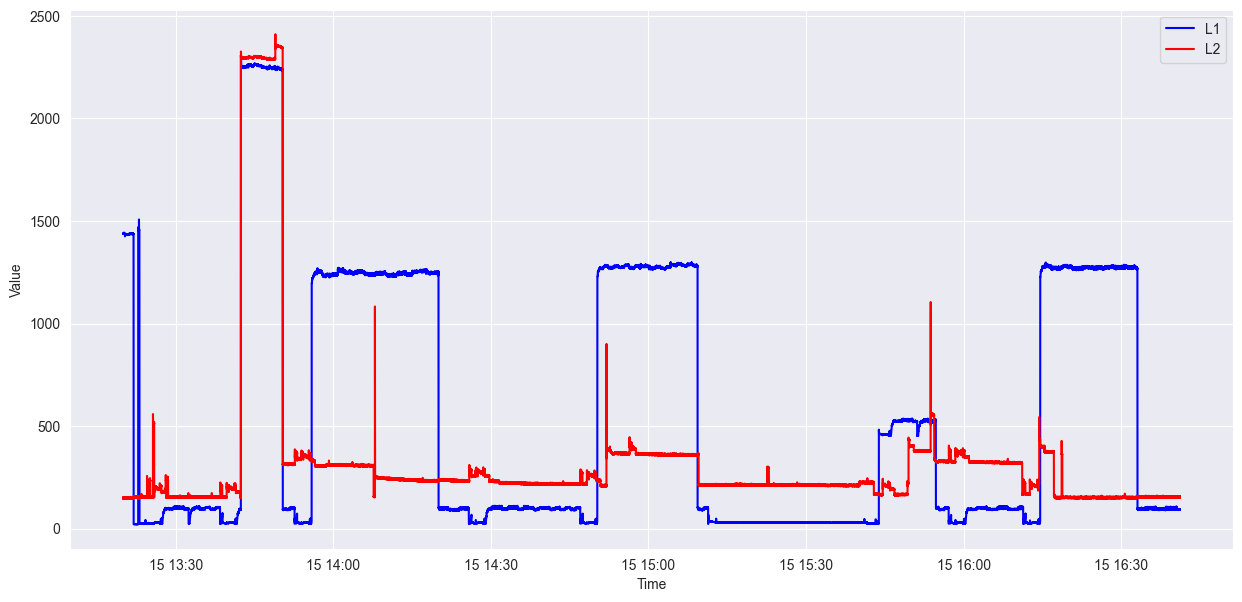

In [309]:
# Example date: 2023-10-10 12:00:00
def zoomIn(start_time: string, end_time: string, time_ticks):
    date_format = "%Y-%m-%d %H:%M:%S"
    # We add two hours because for some reason the start/end index are two hours short
    start_time = (datetime.strptime(start_time, date_format) + timedelta(hours=1)).timestamp()
    end_time = (datetime.strptime(end_time, date_format) + timedelta(hours=1)).timestamp()

    start_index = -1
    end_index = -1
    for index in range(len(TS1_real)):
        if time_ticks[index] > start_time and start_index == -1:
            start_index = index
        if time_ticks[index] > end_time and end_index == -1:
            end_index = index
    return start_index, end_index


start_index, end_index = zoomIn("2012-06-15 14:20:00", "2012-06-15 17:41:10", time_ticks1_np)
plt.figure(figsize=(15, 7))

#This plots total power consumption (zoomed in)
# plt.plot(TS2_real[start_index:end_index], power[start_index:end_index], linestyle='-', color='g', label='phase 1 + phase 2')

#This plots total power consumption
# plt.plot(TS1_real, power, linestyle='-', color='g', label='phase 1 + phase 2')

# This plots phase 1 and phase 2 separately (zoomed in)
plt.plot(TS1_real[start_index:end_index], L1_actual_power[start_index:end_index], linestyle='-', color='b', label='L1')
plt.plot(TS1_real[start_index:end_index], L2_actual_power[start_index:end_index], linestyle='-', color='r', label='L2')

# This plots phase 1 and phase 2 separately (whole thing)
# plt.plot(TS1_real, L1_actual_power, linestyle='-', color='b', label='L1')
# plt.plot(TS2_real, L2_actual_power, linestyle='-', color='r', label='L2')

# plt.plot(TS1_real[start_index:end_index], power[start_index:end_index], linestyle='-', color='b', label='smooth')
event_times = [TS1_real[i] for i in clean_events_start if start_index <= i <= end_index]
for event_time in event_times:
    plt.axvline(event_time, color='g', linestyle='--')

event_times = [TS1_real[i] for i in clean_events_end if start_index <= i <= end_index]
for event_time in event_times:
    plt.axvline(event_time, color='m', linestyle='--')
# plt.plot(TS1_real, power, linestyle='-', color='r', label='power')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

9


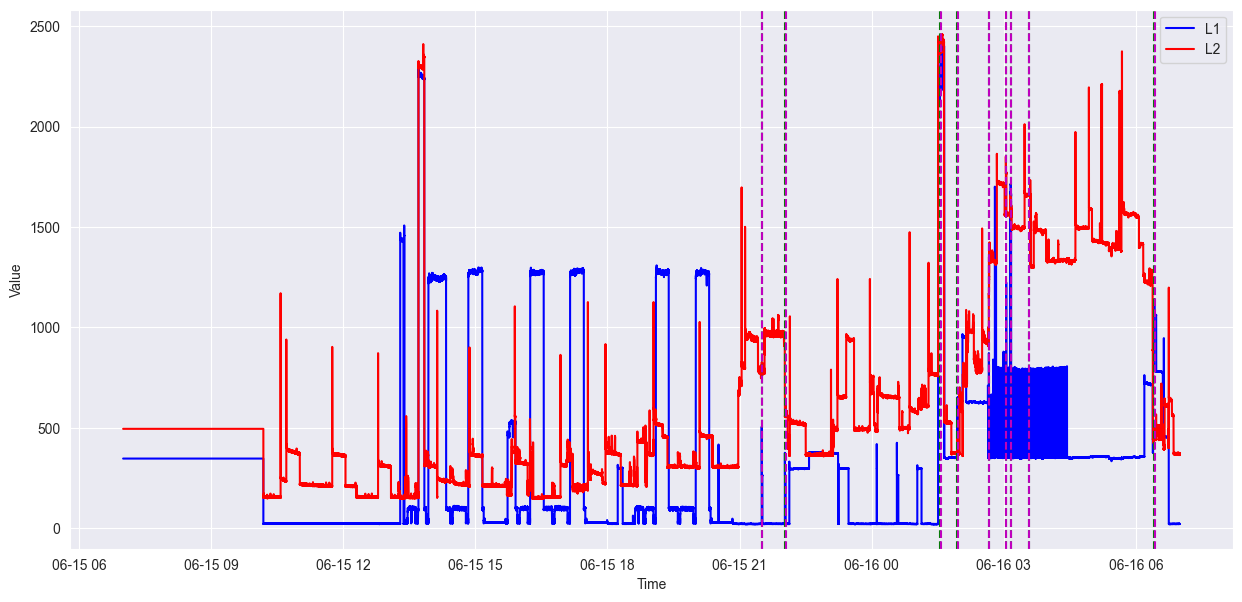

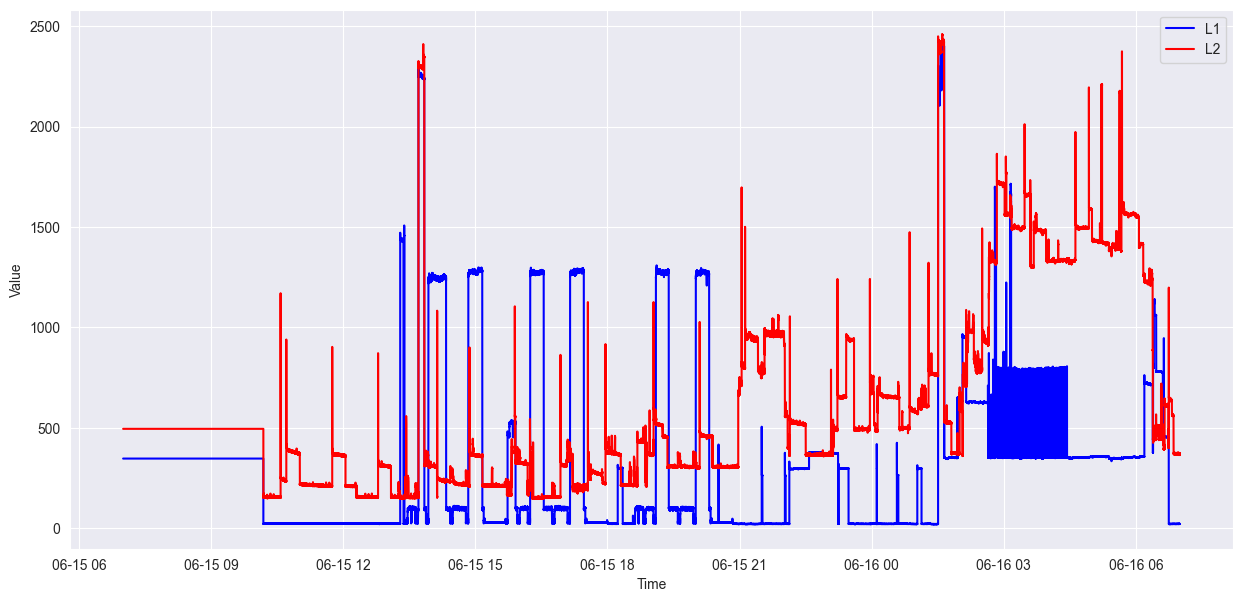

ValueError: x and y must have same first dimension, but have shapes (518922,) and (518943,)

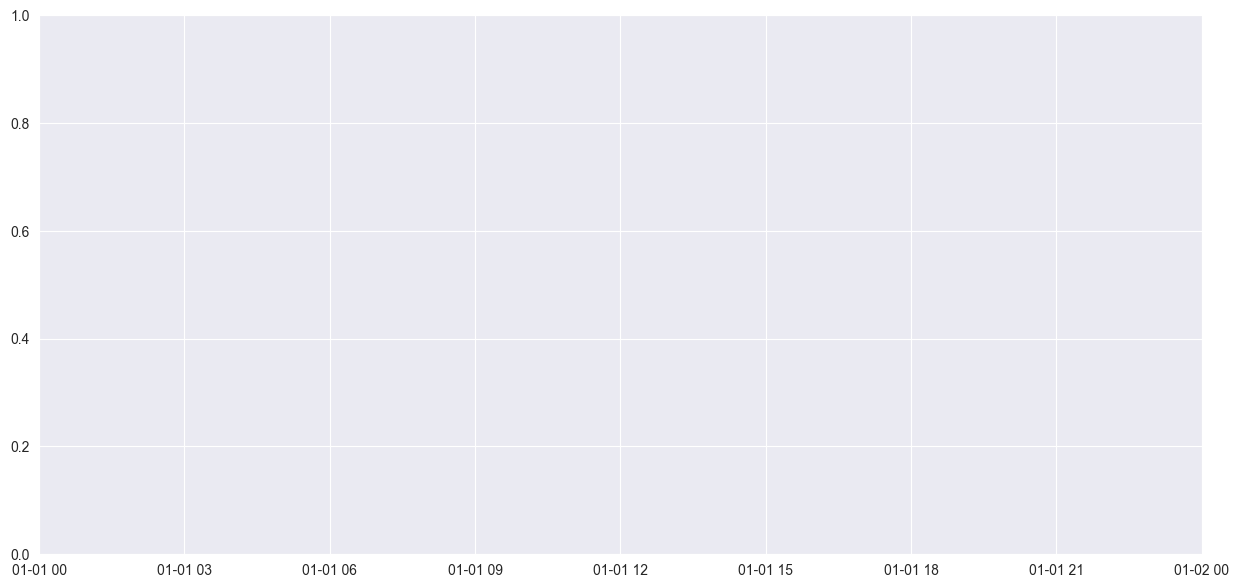

In [310]:
plt.figure(figsize=(15, 7))
plt.plot(TS1_real, L1_actual_power, linestyle='-', color='b', label='L1')
plt.plot(TS2_real, L2_actual_power, linestyle='-', color='r', label='L2')
event_times = [TS1_real[i] for i in clean_events_start]
print(len(event_times))
for event_time in event_times:
    plt.axvline(event_time, color='g', linestyle='--')

event_times = [TS1_real[i] for i in clean_events_end]
for event_time in event_times:
    plt.axvline(event_time, color='m', linestyle='--')
# plt.plot(TS1_real, power, linestyle='-', color='r', label='power')

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(TS1_real, L1_actual_power, linestyle='-', color='b', label='L1')
plt.plot(TS2_real, L2_actual_power, linestyle='-', color='r', label='L2')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(TS1_real, power, linestyle='-', color='b', label='L1')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

# Working on the model

###

In [83]:
normalized_phase1 = normalize(L1_actual_power)
normalized_phase2 = normalize(L2_actual_power)

###